In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
import uproot as ur
import re

In [2]:
with open("LG63HG63Ped.pkl", 'rb') as file:
    ped = pickle.load(file)
with open("MIPs.pkl", 'rb') as file:
    mip = pickle.load(file)
with open("HG63LG63Ratio.pkl", 'rb') as file:
    ratio = pickle.load(file)
with open("geometry.pkl", 'rb') as file:
    geometry = pickle.load(file)

In [54]:
input_file = f'beam_data/run2.root'

events = ur.open("%s:raw"%(input_file))

In [55]:
beam = {}

for ch_key in events.keys():
    match = re.match(r"ch_(\d+)", ch_key)
    if not match:
        continue

    ID = int(match.group(1))
    values = np.array(events[ch_key])  # (n_events, 2) — each row is (LG, HG)

    # Initialize lists
    if f"{ID}_LG" not in beam:
        beam[f"{ID}_LG"] = []
        beam[f"{ID}_HG"] = []

    for i, (LG, HG) in enumerate(values):
        beam[f"{ID}_LG"].append(float(LG))
        beam[f"{ID}_HG"].append(float(HG))

Text(0, 0.5, 'Count')

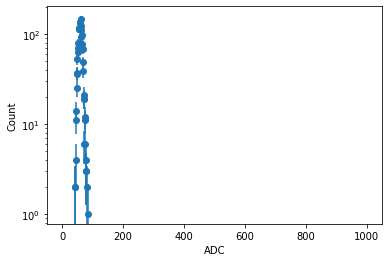

In [67]:
data = np.array(beam["12_LG"])
counts, bin_edges = np.histogram(data, bins=1000, range=[0, 1000])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
plt.errorbar(bin_centers, counts, yerr=errors, fmt='o')
plt.yscale('log')
#plt.ylim(1,25)
plt.xlabel("ADC")
plt.ylabel("Count")


In [40]:
print(beam['67_LG'])

[56.0, 50.0, 41.0, 63.0, 54.0, 48.0, 50.0, 55.0, 48.0, 48.0, 64.0, 54.0, 47.0, 60.0, 75.0, 61.0, 66.0, 58.0, 58.0, 65.0, 38.0, 60.0, 49.0, 36.0, 55.0, 62.0, 72.0, 53.0, 62.0, 34.0, 62.0, 54.0, 56.0, 66.0, 58.0, 48.0, 55.0, 59.0, 71.0, 72.0, 67.0, 63.0, 64.0, 90.0, 65.0, 55.0, 59.0, 57.0, 53.0, 43.0, 60.0, 44.0, 76.0, 79.0, 53.0, 65.0, 59.0, 78.0, 64.0, 52.0, 55.0, 59.0, 61.0, 55.0, 57.0, 64.0, 43.0, 50.0, 61.0, 67.0, 47.0, 57.0, 56.0, 72.0, 51.0, 61.0, 57.0, 70.0, 47.0, 79.0, 39.0, 68.0, 46.0, 51.0, 58.0, 75.0, 38.0, 57.0, 65.0, 64.0, 56.0, 71.0, 56.0, 60.0, 42.0, 72.0, 59.0, 56.0, 67.0, 74.0, 61.0, 48.0, 57.0, 50.0, 56.0, 60.0, 62.0, 56.0, 46.0, 55.0, 63.0, 58.0, 50.0, 113.0, 65.0, 62.0, 59.0, 82.0, 54.0, 77.0, 66.0, 55.0, 55.0, 52.0, 49.0, 44.0, 48.0, 62.0, 71.0, 62.0, 57.0, 63.0, 58.0, 58.0, 66.0, 64.0, 53.0, 31.0, 47.0, 49.0, 65.0, 59.0, 64.0, 58.0, 43.0, 61.0, 77.0, 43.0, 66.0, 49.0, 56.0, 45.0, 61.0, 37.0, 60.0, 53.0, 66.0, 56.0, 61.0, 67.0, 54.0, 44.0, 56.0, 50.0, 64.0, 73.0, 56

In [45]:
def get_chIDs_by_layer(df, layer_number):
    ch_ids = []
    for ch_str in df[df['Layer'] == layer_number]['Ch#']:
        CAEN, ch = map(int, ch_str.split('-'))
        ch_id = ch + (64 * (CAEN - 1))
        ch_ids.append(ch_id)
    return ch_ids
def get_LG_array_by_layer(geometry, din):
    all_layers = sorted(geometry['Layer'].unique())
    layer_data = []

    for layer in all_layers:
        ch_ids = get_chIDs_by_layer(geometry, layer)
        combined = [din[f"{ID}_LG"] for ID in ch_ids if f"{ID}_LG" in din]
        if combined:
            layer_data.append(np.concatenate(combined))
        else:
            layer_data.append(np.array([]))  # empty array if no matches

    return layer_data

In [46]:
beam_lg_mips = {}

for i in range(64*6):  # Adjust range if needed
    key_lg = f"{i}_LG"
    
    if key_lg in beam:
        raw_values = beam[key_lg]
        ped_mean = ped['LGPedMean'][i]
        ped_sigma = ped['LGPedSigma'][i]
        ratio_i = ratio[i]
        mip_i = mip[i]

        mips_values = []
        for val in raw_values:
            val_subtracted = val - ped_mean
            # Apply suppression
            if val_subtracted < 3 * ped_sigma:
                mips_values.append(0)
            else:
                # Avoid division by zero
                if ratio_i == 0 or mip_i == 0:
                    
                    mips_values.append(0)
                else:
                    val_mip = (val_subtracted * ratio_i) / mip_i
                    mips_values.append(val_mip)
        
        beam_lg_mips[key_lg] = mips_values

In [54]:
with open('HG63LG63BeamCal2.pkl', 'wb') as f:
    pickle.dump(beam_lg_mips, f)